In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice

In [2]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_telephone_LM(beta, data):
    beta_cost = -1.9
    # Define utility functions
    data['U_1'] = beta[0] + beta_cost * data['logcost1'] 
    data['U_2'] = beta_cost * data['logcost2'] 
    data['U_3'] = beta[1] + beta_cost * data['logcost3']
    data['U_4'] = beta[2] + beta_cost * data['logcost4']
    data['U_5'] = beta[3] + beta_cost * data['logcost5']

    sum_total = np.exp(data['U_1']) * data['avail1'] + np.exp(data['U_2']) * data['avail2'] + \
                np.exp(data['U_3']) * data['avail3'] + np.exp(data['U_4']) * data['avail4'] + \
                np.exp(data['U_5']) * data['avail5']
    
    # Full probabilities
    data['P_1'] = np.exp(data['U_1']) * data['avail1'] / sum_total
    data['P_2'] = np.exp(data['U_2']) * data['avail2'] / sum_total
    data['P_3'] = np.exp(data['U_3']) * data['avail3'] / sum_total
    data['P_4'] = np.exp(data['U_4']) * data['avail4'] / sum_total
    data['P_5'] = np.exp(data['U_5']) * data['avail5'] / sum_total
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [3]:
# Load data
data = pd.read_csv('../data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0])

beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5"]

# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_LM)


Optimization Results:
  Parameter  Estimate  Robust Asymptotic SE  t-statistic   p-value
0     ASC_1 -0.701841              0.149735    -4.687225  0.000004
1     ASC_3  1.144412              0.121680     9.405067  0.000000
2     ASC_4  0.945912              0.700523     1.350295  0.177632
3     ASC_5  1.615552              0.183723     8.793434  0.000000
AIC: 963.4683080643189
BIC: 979.7604862007205


---
---
---
---
---

<h2> Multinomial lognormal distribution on raw data </h2>

In [4]:
from functions_geom_DIB import geom_DIB_on_alternatives

In [5]:
def multivariate_lognormal_pdf(x, mu, sigma):
    """
    Compute the probability density function (PDF) of a multivariate lognormal distribution.

    Parameters:
        x (ndarray): Vector in log space.
        mu (ndarray): Mean vector.
        sigma (ndarray): Covariance matrix.

    Returns:
        float: Value of the PDF at x.
    """
    n = len(x)
    
    # Compute the PDF of a multivariate normal distribution
    exponent = -0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu)
    mvn_pdf = (1 / ((2 * np.pi) ** (n / 2) * np.sqrt(np.linalg.det(sigma)))) * np.exp(exponent)
    
    # Compute the Jacobian determinant term and remove x = 0 elements
    jacobian = np.prod(1 / x)

    pdf = jacobian * mvn_pdf

    # Compute the PDF of the multivariate lognormal distribution
    
    return pdf

In [6]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()
covariance_matrix = log_df_logcost.cov()

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13015/2939645465.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix), axis=1)


In [7]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values


p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [8]:
np.random.seed(123)
data['simulated_choice'] = data.apply(simulate_choice, axis=1)

Iteration: 1 out of 5000
Iteration: 1 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000


Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5

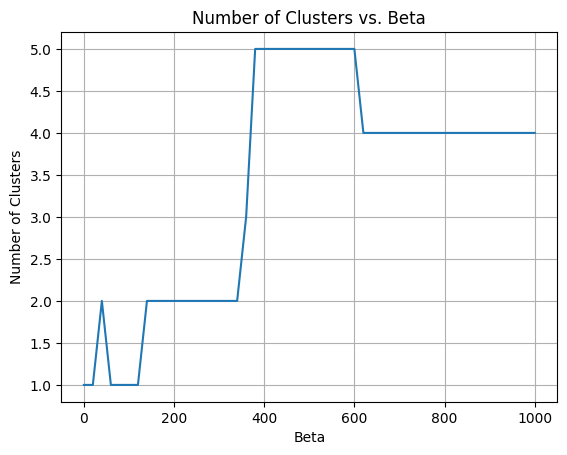

In [9]:
betas = np.linspace(0, 1000, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [10]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=200, max_iter=5000, threshold=1e-10)

Iteration: 1 out of 5000
Iteration: 2 out of 5000


In [11]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 2

 cluster
0    425
2      9
Name: count, dtype: int64

 choice    1    2    3  4   5
cluster                     
0        71  122  175  0  57
2         2    1    3  3   0

 max_proba   1    2    3  4   5
cluster                       
0          46  108  234  0  37
2           0    0    7  2   0

 simulated_choice   1    2    3  4   5
cluster                              
0                 68  132  164  1  60
2                  2    1    3  3   0
